In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from environments.utils import create_data
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_rows = 4000

In [7]:
train, test = create_data(start_='2000-01-01',end_='2023-04-13',scale_min_max=False)

In [8]:
train

,open,high,low,close,volume,ADL,ADX,AO,ATR,BBWIDTH,...,WILLIAMS,WMA,WOBV,ZLEMA,sin_weekday,cos_weekday,sin_monthday,cos_monthday,sin_yearday,cos_yearday
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,9.318000e+08,-1.391598e+08,100.000000,-31.517570,26.342128,0.081278,...,-36.523160,1435.604009,-5.630213e+10,1435.919922,0.000000,1.000000,0.571268,0.820763,0.051620,0.998667
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1.009000e+09,-1.078670e+09,100.000000,-31.517570,26.342128,0.081278,...,-36.523160,1435.604009,-5.630213e+10,1435.919922,0.781831,0.623490,0.724793,0.688967,0.068802,0.997630
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1.085500e+09,-6.739360e+08,100.000000,-31.517570,26.342128,0.081278,...,-36.523160,1435.604009,-5.338219e+10,1435.919922,0.974928,-0.222521,0.848644,0.528964,0.085965,0.996298
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1.092300e+09,-5.139585e+08,100.000000,-31.517570,26.342128,0.081278,...,-36.523160,1435.604009,-5.191855e+10,1435.919922,0.433884,-0.900969,0.937752,0.347305,0.103102,0.994671
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1.225200e+09,7.112415e+08,100.000000,-31.517570,26.342128,0.081278,...,-36.523160,1435.604009,-5.336422e+09,1435.919922,-0.433884,-0.900969,0.988468,0.151428,0.120208,0.992749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-08,2856.790039,2862.439941,2853.090088,2857.699951,2.978070e+09,1.481261e+12,11.879785,54.643525,19.571394,0.028649,...,-8.390653,2840.982883,2.051656e+12,2847.983232,0.974928,-0.222521,0.998717,-0.050649,-0.601624,-0.798779
2018-08-09,2857.189941,2862.479980,2851.979980,2853.580078,3.066180e+09,1.479130e+12,11.823401,60.511726,19.629255,0.029281,...,-14.423558,2845.361339,2.039024e+12,2850.855604,0.433884,-0.900969,0.968077,-0.250653,-0.615285,-0.788305
2018-08-10,2838.899902,2842.199951,2825.810059,2833.280029,3.265590e+09,1.478841e+12,11.631424,58.314783,20.650670,0.028381,...,-44.939592,2844.907340,1.972732e+12,2848.606300,-0.433884,-0.900969,0.897805,-0.440394,-0.628763,-0.777597


In [9]:
# calculate intersect over union of ranges of values in train and test for every column
def iou(train_, test_):
    iou = []
    for col in train_.columns:
        train_range = train_[col].max() - train_[col].min()
        test_range = test_[col].max() - test_[col].min()
        intersect = max(min(train_[col].max(), test_[col].max()) - max(train_[col].min(), test_[col].min()),0)
        union = train_range + test_range - intersect
        iou.append((col, intersect / union))
    return iou

('DYMI', 1.0)
('EVSTC', 1.0)
('SQZMI', 1.0)
('STC', 1.0)
('STOCH', 1.0)
('WILLIAMS', 1.0)
('sin_weekday', 1.0)
('cos_weekday', 1.0)
('sin_monthday', 1.0)
('cos_monthday', 1.0)
('sin_yearday', 1.0)
('cos_yearday', 1.0)
('BOP', 0.9979898065135291)
('STOCHD', 0.995317256617584)
('IFT_RSI', 0.9897615710467186)
('ER', 0.9681041058461901)
('PZO', 0.9646994227518653)
('BBWIDTH', 0.9474363702999118)
('FVE', 0.9432392871116955)
('ROC', 0.9285379521660487)
('VZO', 0.9285224296463555)
('PERCENT_B', 0.9237131804203808)
('UO', 0.9224985923927684)
('TRIX', 0.9109208721186449)
('CCI', 0.9056750516101221)
('MI', 0.9045329345898863)
('MFI', 0.8786060260191438)
('COPP', 0.8632400781499523)
('CMO', 0.8573665144283614)
('FISH', 0.7885645010480463)
('volume', 0.7819698094441881)
('VFI', 0.7585376014575123)
('CHAIKIN', 0.7562860790292699)
('RSI', 0.752620619862348)
('STOCHRSI', 0.7461233443713902)
('EMV', 0.6608671899339579)
('CFI', 0.6515889532440401)
('WOBV', 0.6351190204293674)
('VBM', 0.5546643454249051

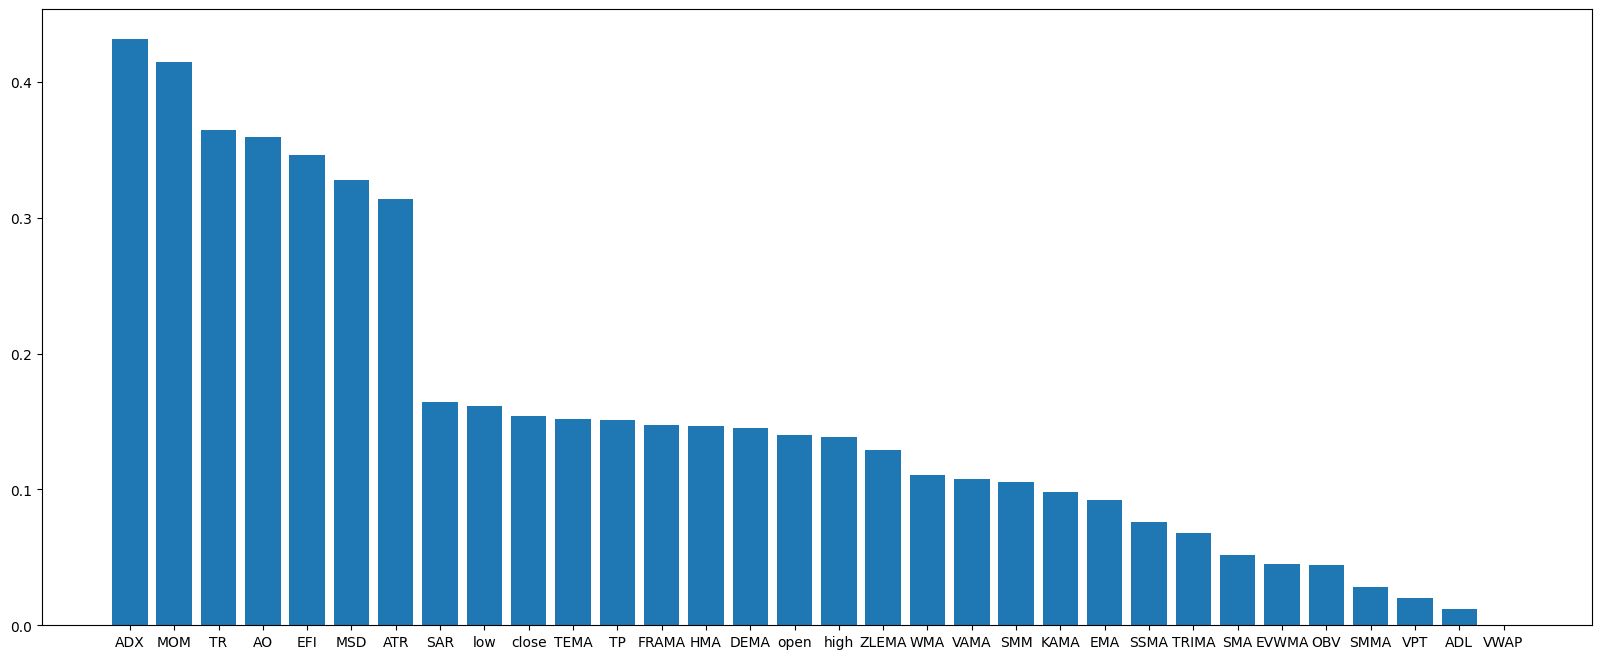

In [10]:
# sort columns by iou and print their iou values and names
# plot sorted values in a bar chart
iou_ = iou(train, test)
iou_.sort(reverse=True, key=lambda x: x[1])
for i in iou_:
    print(i)
fig, ax = plt.subplots(figsize=(20, 8))
plt.bar([i[0] for i in iou_ if i[1] < 0.5], [i[1] for i in iou_ if i[1] < 0.5])
plt.show()

In [11]:
# take the last 6 months and calculate the mean and std of each column
# then scale those 6 months to std with calculated mean and std
# move over one day and repeat
def scale_to_std_using_sliding_windows(train_df, test_df, window_len=6 * 30):
    train_ = train_df.copy()
    test_ = test_df.copy()
    whole_df = pd.concat([train_, test_])
    for i in range(0, len(train_) - window_len+1):
        train_temp = whole_df.iloc[i:i+window_len]
        std_ = train_temp.std()
        mean_ = train_temp.mean()
        train_temp = (train_temp - mean_) / std_
        train_.iloc[i:window_len+i] = train_temp
    for i in range(0, len(test_) - window_len+1):
        test_temp = whole_df.iloc[i:i+window_len]
        std_ = test_temp.std()
        mean_ = test_temp.mean()
        test_temp = (test_temp - mean_) / std_
        test_.iloc[i:window_len+i] = test_temp
    return train_, test_

In [12]:
train_std_180, test_std_180 = scale_to_std_using_sliding_windows(train, test)

In [25]:
train2, test2 = create_data(start_='2000-01-01',end_='2023-04-13',scale_min_max=True)

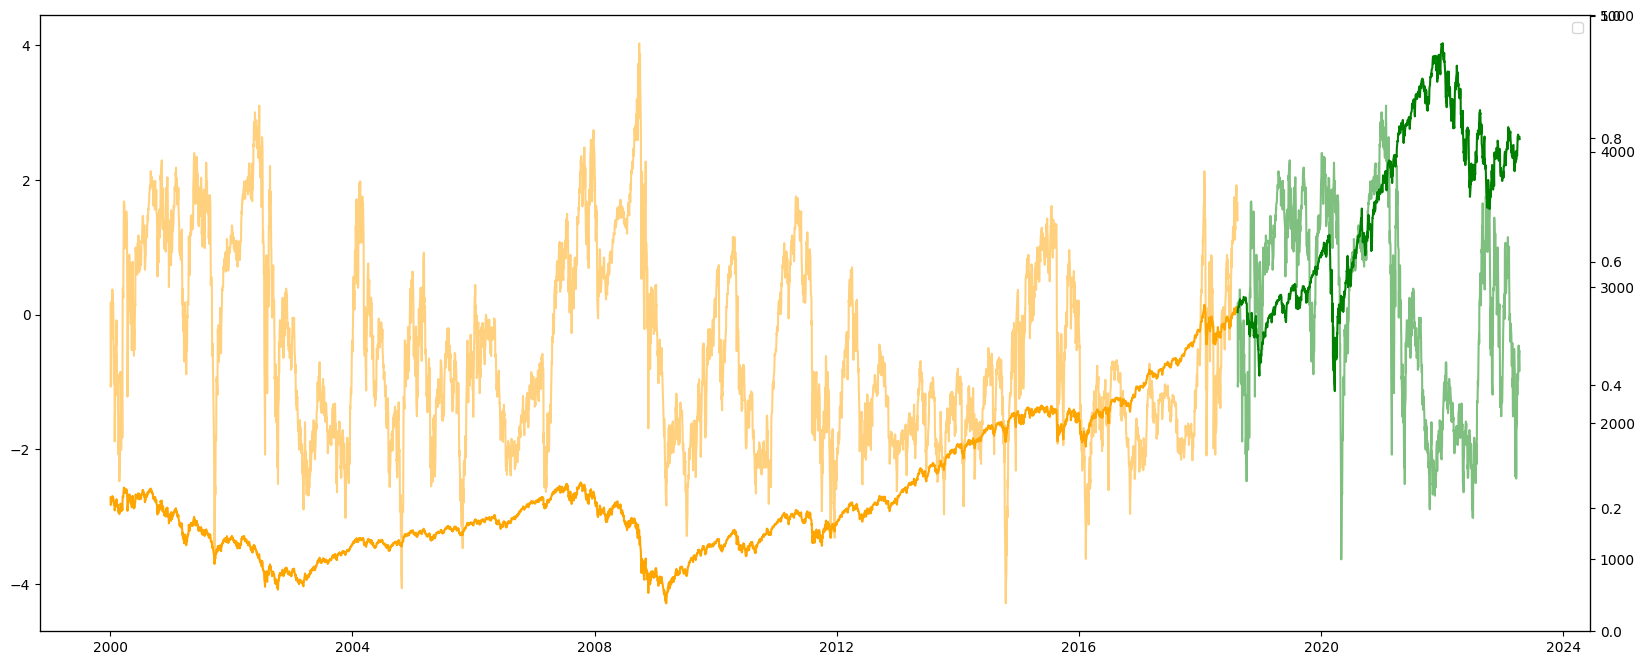

In [28]:
fig, ax1 = plt.subplots(figsize=(20, 8))
ax2 = ax1.twinx()
ax3 = ax1.twinx()
ax1.plot(train_std_180['close'], color='orange', alpha=0.5)
ax1.plot(test_std_180['close'], color='green', alpha=0.5)
ax2.plot(train['close'], color='orange')
ax2.plot(test['close'], color='green')
plt.legend(['train_std_180', 'test_std_180', 'train', 'test'])

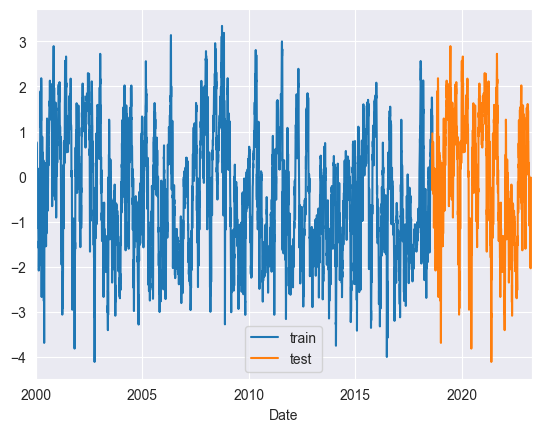

In [59]:
train_std_60, test_std_60 = scale_to_std_using_sliding_windows(train, test, 60)
train_std_60['close'].plot()
test_std_60['close'].plot()
plt.legend(['train', 'test'])

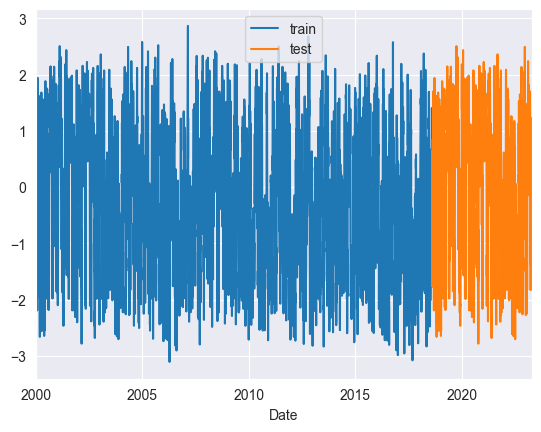

In [60]:
train_std_14, test_std_14 = scale_to_std_using_sliding_windows(train, test, 14)
train_std_14['close'].plot()
test_std_14['close'].plot()
plt.legend(['train', 'test'])

('STC', 1.0)
('cos_monthday', 1.0)
('sin_yearday', 1.0)
('EVSTC', 0.9999999999999266)
('VAMA', 0.9981793015993689)
('cos_yearday', 0.9943681347798871)
('SSMA', 0.9930653817244943)
('IFT_RSI', 0.9911775670057585)
('ATR', 0.9850273295264044)
('SMM', 0.9827887841332201)
('TEMA', 0.9827398050454649)
('EMA', 0.982489763666371)
('SMA', 0.9805010655911848)
('ADX', 0.9802040109264688)
('KAMA', 0.9790345068811513)
('FRAMA', 0.9771462353597593)
('FVE', 0.9756850549399018)
('sin_monthday', 0.9750078856401265)
('sin_weekday', 0.974585915967925)
('WMA', 0.9737751077046432)
('TR', 0.972142114876524)
('EFI', 0.9701262282276688)
('CHAIKIN', 0.9690158156677469)
('volume', 0.9688313539721904)
('PERCENT_B', 0.966028268571986)
('ZLEMA', 0.9659616908834099)
('CCI', 0.9652710382538429)
('PZO', 0.9640138196927147)
('MFI', 0.9627595878550239)
('AO', 0.9625351924218778)
('STOCHRSI', 0.9615821515058697)
('MSD', 0.9606252391994402)
('COPP', 0.9604323805732653)
('EVWMA', 0.9591722544255127)
('DYMI', 0.95758481136

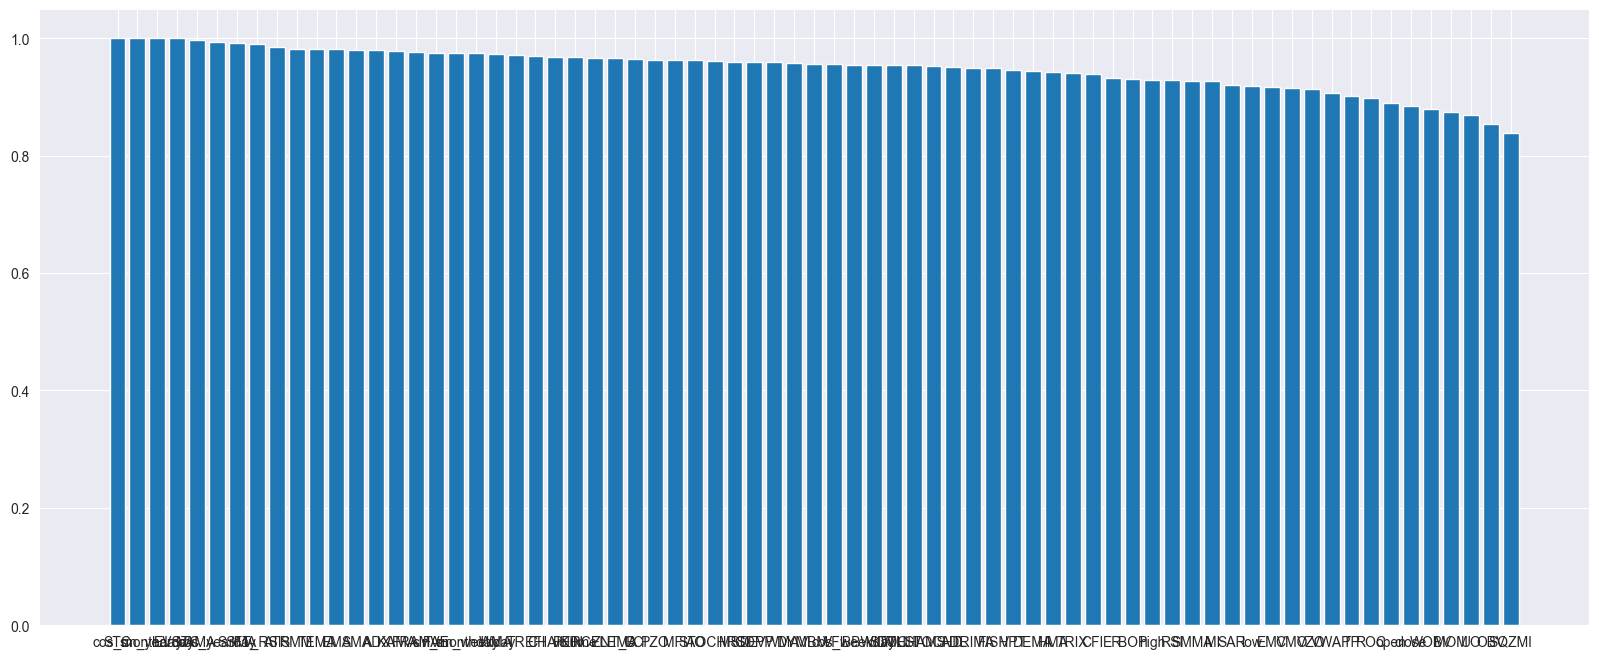

In [63]:
# sort columns by iou and print their iou values and names
# plot sorted values in a bar chart
iou_ = iou(train_std_14, test_std_14)
iou_.sort(reverse=True, key=lambda x: x[1])
for i in iou_:
    print(i)
fig, ax = plt.subplots(figsize=(20, 8))
plt.bar([i[0] for i in iou_], [i[1] for i in iou_])
plt.show()